# Выбор локации для скважины

Добывающей компании необходимо принять решение о месте бурения новой скважину.

Предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов.
Задача - построить модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль.
Необходимо проанализировать возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:
- В избранном регионе ищем месторождения, для каждого определяем значения признаков;
- Строим модель и оцениваем объём запасов;
- Выбираем месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

### Введение

**Данные геологоразведки трёх регионов находятся в файлах:**

- geo_data_0.csv
- geo_data_1.csv
- geo_data_2.csv

**id — уникальный идентификатор скважины;**

**f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);**

**product — объём запасов в скважине (тыс. баррелей) - целевой признак.**

**Условия задачи:**
Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
Бюджет на разработку скважин в регионе — 10 млрд рублей.
При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.
Данные синтетические: детали контрактов и характеристики месторождений не разглашаются.

### Подготовим неоходимые для работы библиотеки

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_squared_error

from google.colab import drive

### Изучим данные внутри датафрейма и сделаем необходимую предобработку

In [ ]:
#напишем для этого функцию, чтобы не дублировать все по несколько раз
def show_info(link):
    data = pd.read_csv(link) #читаем данные по 1 региону в переменную data
    print(link)
    display(data.head()); #выведем первые 5 строк датасета
    display(data.info()); #выведем информацию о типах данных и пропусках в датасете
    display(data.describe()); #выведем информацию о распределении значений в датасете
    display(data.corr()); #посмотрим корреляцию между признаками
    print('\n\n')

QTY_REGIONS = 3 # кол-во регионов
drive.mount('/content/drive')

for i in range(QTY_REGIONS):
    show_info(f'/content/drive/My Drive/projects/oil_wells_profitability_prediction/geo_data_{i}.csv')

/datasets/geo_data_0.csv


,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


,f0,f1,f2,product
f0,1.000000,-0.440723,-0.003153,0.143536
f1,-0.440723,1.000000,0.001724,-0.192356
f2,-0.003153,0.001724,1.000000,0.483663
product,0.143536,-0.192356,0.483663,1.000000





/datasets/geo_data_1.csv


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


,f0,f1,f2,product
f0,1.000000,0.182287,-0.001777,-0.030491
f1,0.182287,1.000000,-0.002595,-0.010155
f2,-0.001777,-0.002595,1.000000,0.999397
product,-0.030491,-0.010155,0.999397,1.000000





/datasets/geo_data_2.csv


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


,f0,f1,f2,product
f0,1.000000,0.000528,-0.000448,-0.001987
f1,0.000528,1.000000,0.000779,-0.001012
f2,-0.000448,0.000779,1.000000,0.445871
product,-0.001987,-0.001012,0.445871,1.000000


**Видим, что данные по каждому из регионов не имеют пропусков и каких-то аномалий в типах, требующих исправлений.**

**Достаточно странный момент - это почти полная корреляция в данных региона 2 двух признаков: признака f2 и целевого признака product.**

**Удалим неинформативный признак `'id'` из каждого датасета.**

In [ ]:
#напишем функцию, которая удаляет из каждого датасета в списке нужный признак
def delete_column(link_list, column):
    for i in range(len(link_list)):
        df = pd.read_csv(link_list[i])
        df = df.drop([column], axis=1)
        df_list.append(df)
    return df_list

link_list = [] # создаем список для ссылок датасетов
df_list = [] # создаем список датафреймов

#заполняем список ссылок датасетов
for i in range(QTY_REGIONS):
    link_list.append(f'/content/drive/My Drive/projects/oil_wells_profitability_prediction/geo_data_{i}.csv')

#заполним список датафреймов
df_list = delete_column(link_list, 'id')
df_list

[             f0        f1        f2     product
 0      0.705745 -0.497823  1.221170  105.280062
 1      1.334711 -0.340164  4.365080   73.037750
 2      1.022732  0.151990  1.419926   85.265647
 3     -0.032172  0.139033  2.978566  168.620776
 4      1.988431  0.155413  4.751769  154.036647
 ...         ...       ...       ...         ...
 99995  0.971957  0.370953  6.075346  110.744026
 99996  1.392429 -0.382606  1.273912  122.346843
 99997  1.029585  0.018787 -1.348308   64.375443
 99998  0.998163 -0.528582  1.583869   74.040764
 99999  1.764754 -0.266417  5.722849  149.633246
 
 [100000 rows x 4 columns],
               f0         f1        f2     product
 0     -15.001348  -8.276000 -0.005876    3.179103
 1      14.272088  -3.475083  0.999183   26.953261
 2       6.263187  -5.948386  5.001160  134.766305
 3     -13.081196 -11.506057  4.999415  137.945408
 4      12.702195  -8.147433  5.004363  134.766305
 ...          ...        ...       ...         ...
 99995   9.535637  -6.878

## Обучение и проверка модели

### Разделение данных на выборки

**Разобъем данные для каждого из 3 регионов на обучающую и валидационную выборки в соотношении 75:25, масштабируем численные признаки.**

In [ ]:
# напишем функцию, которая масштабирует признаки
# и разбивает список датасетов на списки тренировочных выборок и валидационных выборок
def data_dev_std(df_list, target_column, test_size, numeric):
    pd.options.mode.chained_assignment = None # для "нейтрализации" ошибки стандартизации
    features_train_list = []
    features_valid_list = []
    target_train_list = []
    target_valid_list = []
    i = 0
    # разделим датасет на обучающую и валидационные выборки
    for df in df_list:
        target = df[target_column]
        features = df.drop([target_column], axis = 1)
        features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size=test_size, random_state=i)
        # нормализуем численные признаки
        scaler = StandardScaler()
        scaler.fit(features_train[numeric])
        features_train[numeric] = scaler.transform(features_train[numeric])
        features_valid[numeric] = scaler.transform(features_valid[numeric])
        # запишем полученные выборки в соответствующие списки
        features_train_list.append(features_train)
        features_valid_list.append(features_valid)
        target_train_list.append(target_train)
        target_valid_list.append(target_valid)
        i += 1
    return features_train_list, features_valid_list, target_train_list, target_valid_list

features_train_list = []
features_valid_list = []
target_train_list = []
target_valid_list = []

features_train_list, features_valid_list, target_train_list, target_valid_list = data_dev_std(df_list, 'product', 0.25, ['f0', 'f1', 'f2'])

# выведем на экран размеры получившихся выборок
for i in range(QTY_REGIONS):
    print('\n')
    print(f'{i+1}-й регион. features_train:')
    display(features_train_list[i].shape)
    print(f'{i+1}-й регион. features_valid:')
    display(features_valid_list[i].shape)
    print(f'{i+1}-й регион. target_train:')
    display(target_train_list[i].shape)
    print(f'{i+1}-й регион. target_valid:')
    display(target_valid_list[i].shape)



1-й регион. features_train:


(75000, 3)

1-й регион. features_valid:


(25000, 3)

1-й регион. target_train:


(75000,)

1-й регион. target_valid:


(25000,)



2-й регион. features_train:


(75000, 3)

2-й регион. features_valid:


(25000, 3)

2-й регион. target_train:


(75000,)

2-й регион. target_valid:


(25000,)



3-й регион. features_train:


(75000, 3)

3-й регион. features_valid:


(25000, 3)

3-й регион. target_train:


(75000,)

3-й регион. target_valid:


(25000,)

### Обучение моделей для каждого региона и предсказания на валидационных
### Сохранение предсказаний и правильных ответов на валидационной выборке
### Вывод на экран среднего запаса предсказанного сырья и RMSE каждой модели

In [ ]:
predictions_valid_list = [] # список с предсказаниями для каждого региона на валидационных выборках
rmse_list = [] # список со значениями RMSE для предсказаний каждой модели для каждого региона на валидационных данных
mean_pred_oil_reserves_list = [] # список со значениями среднего запаса предсказанного сырья для каждого региона

for i in range(QTY_REGIONS):
    model = LinearRegression() # инициализируем модель LinearRegression
    model.fit(features_train_list[i], target_train_list[i]) # обучим модель на тренировочной выборке
    # получим предсказания модели на валидационной выборке и добавим в список
    predictions_valid_list.append(model.predict(features_valid_list[i]))
    # получим значение метрики rmse для каждой модели на валидационных данных и добавим в список
    rmse_list.append(mean_squared_error(target_valid_list[i], predictions_valid_list[i], squared=False))
    mean_pred_oil_reserves_list.append(predictions_valid_list[i].mean())

    # список значений RMSE для моделей, обученных для каждого региона
print(f'RMSE для регионов, тыс. баррелей:{[round(rmse, 3) for rmse in rmse_list]}')
# список среднего запаса предсказанного сырья по регионам
print(f'Средний запас предсказанного сырья по регионам, тыс. баррелей:{[round(feedstock, 3) for feedstock in mean_pred_oil_reserves_list]}')

RMSE для регионов, тыс. баррелей:[37.481, 0.894, 39.985]
Средний запас предсказанного сырья по регионам, тыс. баррелей:[92.271, 69.12, 94.86]


### Анализ результатов

**Полученные результаты позволяют сделать следующие выводы:**
- Регион 3 и 1 имеют наибольшие значения среднего запаса предсказанного сырья, однако, с учетом значения RMSE для каждой из модели результаты не столь однозначны, т.к. с учетом ошибки средний запас предсказанного сырья может оказаться наибольшим для региона 2.
- Метрика RMSE наилучшее (наименьшее) значение имеет для модели, обученной на данных региона 2, что логично, т.к. в начале мы обнаружили полную корреляцию признака f2 и целевого признака для данного региона.


## Подготовка к расчёту прибыли

### Сохраняем все ключевые значения для расчётов в отдельных переменных

При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
Бюджет на разработку скважин в регионе — 10 млрд рублей.
При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.

In [ ]:
ONE_REGION_BUDGET = 10 ** 10 # бюджет на разработку скважин в одном регионе
ONE_UNIT_INCOME = 4.5 * 10 ** 5 # доход с единицы продукта (1 тыс. баррелей)
EXPLORE_COUNT = 500 # кол-во точек при разведке региона
TOP_COUNT = 200 # кол-во лучших точек для разработки

### Рассчитаем достаточный объём сырья для безубыточной разработки новой скважины

Распределение запасов сырья для 1-го региона


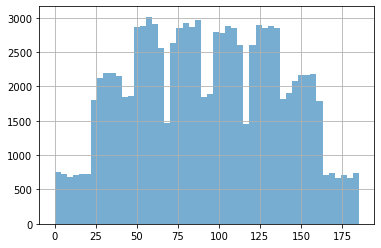



Распределение запасов сырья для 2-го региона


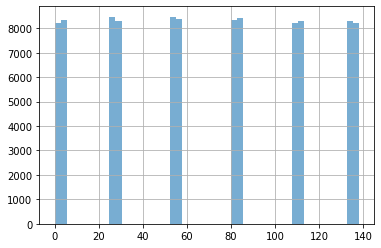



Распределение запасов сырья для 3-го региона


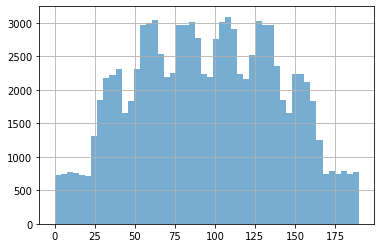



Средний запас в скважинах по регионам, тыс. баррелей:[92.5, 68.825, 95.0]
Достаточный объём сырья для безубыточной разработки новой скважины 111.111 тыс. баррелей


In [ ]:
mean_oil_reserves_list = [] # список среднего запаса сырья по регионам
for i in range(QTY_REGIONS):
    mean_oil_reserves_list.append(df_list[i]['product'].mean())
    print(f'Распределение запасов сырья для {i+1}-го региона')
    df_list[i]['product'].hist(bins=50, alpha=0.6)
    plt.show()
    print('\n')

print(f'Средний запас в скважинах по регионам, тыс. баррелей:{[round(oil, 3) for oil in mean_oil_reserves_list]}')
brkevn_amnt = ONE_REGION_BUDGET / TOP_COUNT / ONE_UNIT_INCOME
print(f'Достаточный объём сырья для безубыточной разработки новой скважины {brkevn_amnt:.3f} тыс. баррелей')

### Сравнение полученного объёма сырья со средним запасом в каждом регионе

**Видим, что достаточный объем сырья для безубытка для одной скважины превышает средние значения по каждому региону.**

### Выводы по этапу подготовки расчёта прибыли.

**Можно сделать вывод, что несмотря на тот факт, что средние объемы сырья в регионах недостаточны для безубыточной разработки новых 200 скважин, исходя из гистограммы вероятность попасть на 200 скважин, которые будут безубыточны не нулевая и на первый взгляд выше для региона 1 и 3.**

## Расчёт прибыли и рисков

###  Выберем скважины с максимальными значениями предсказаний
### Просуммируем целевое значение объёма сырья, соответствующее этим предсказаниям
### Рассчитаем прибыль для полученного объёма сырья

In [ ]:
# напишем функцию для расчёта прибыли по скважинам с макс. значениями предсказаний моделей
def profit_calc(predictions, target, count, one_unit_income, budget):
    pred_index = predictions.sort_values(ascending=False).iloc[:count].index
    target_top = target.reset_index(drop=True).iloc[predictions.sort_values(ascending=False).iloc[:count].index]
    target_sum_value = target_top.sum()
    target_sum_income = target_sum_value * one_unit_income - budget
    return target_sum_income

target_top_income_list = [] # список суммарной прибыли с топ-200 скважин для каждого региона
for i in range(QTY_REGIONS):
    target_top_income_list.append(
        profit_calc(pd.Series(predictions_valid_list[i]), target_valid_list[i], TOP_COUNT, ONE_UNIT_INCOME, ONE_REGION_BUDGET)
    )
[round(income, 3) for income in target_top_income_list] # чистая прибыль для каждого региона по топ-200 скважин

[3363408079.608, 2415086696.682, 2426986816.696]

**Проверим теперь прибыль для каждого региона при условии, что при разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.**

In [ ]:
target_exmpl_top_income_list = [] # список суммарной прибыли для топ-200 скважин среди 500 случайных для каждого региона

for i in range(QTY_REGIONS):
    examples = pd.Series(predictions_valid_list[i]).sample(n=EXPLORE_COUNT, random_state=i) # выделение случайных 500 скважин
    # расчет суммарной прибыли для примера
    target_exmpl_top_income_list.append(
        profit_calc(examples, target_valid_list[i], TOP_COUNT, ONE_UNIT_INCOME, ONE_REGION_BUDGET)
    )
[round(income, 3) for income in target_exmpl_top_income_list]# чистая прибыль для каждого региона для топ-200 взятых из случайных 500 скважин

[801467788.263, 294383385.442, 197709200.136]

## Риски и прибыль в каждом регионе

 ### Применим технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли

In [ ]:
state = np.random.RandomState(1)
income_distr_regions_list = [] # список, куда сохраняем распределение income для каждого региона
for i in range(QTY_REGIONS):
    values = [] # список, куда сохраняем список значений income для одного региона
    for j in range(1000):
        subsample = pd.Series(predictions_valid_list[i]).sample(n=EXPLORE_COUNT, replace=True, random_state=state)
        values.append(
            profit_calc(subsample, target_valid_list[i], TOP_COUNT, ONE_UNIT_INCOME, ONE_REGION_BUDGET)
        )
    income_distr_regions_list.append(pd.Series(values))

income_distr_regions_list

[0      5.988635e+08
 1      5.432469e+08
 2      2.675469e+08
 3      3.740575e+08
 4      8.103343e+08
            ...     
 995    3.783639e+08
 996    1.012018e+09
 997    2.335590e+08
 998    6.104321e+08
 999    5.729309e+08
 Length: 1000, dtype: float64,
 0      6.196885e+08
 1      2.644031e+08
 2      3.022206e+08
 3      2.108490e+08
 4      4.570359e+08
            ...     
 995    1.317308e+08
 996    5.968612e+08
 997    3.292775e+08
 998    8.857794e+08
 999    1.616489e+08
 Length: 1000, dtype: float64,
 0     -1.450709e+08
 1      3.892880e+08
 2      2.618746e+08
 3     -6.711486e+06
 4      4.891680e+08
            ...     
 995    1.045231e+08
 996    7.447905e+07
 997    4.248850e+08
 998    6.327871e+08
 999    3.426122e+08
 Length: 1000, dtype: float64]

 ### Найдем среднюю прибыль, 95%-й доверительный интервал и риск убытков. Убытком считаем отрицательную прибыль

**Найдем среднюю прибыль для каждого региона.**

In [ ]:
mean_income_regions_list = [] # список со средней прибылью для каждого региона
for i in range(QTY_REGIONS):
    mean_income_regions_list.append(income_distr_regions_list[i].mean())
[round(income, 3) for income in mean_income_regions_list]

[448303912.549, 483358669.718, 287541286.707]

**Найдем 95%-й доверительный интервал для каждого региона.**

In [ ]:
conf_intervals_regions_list = [] # список с 95% доверительным интервалом для каждого региона
for i in range(QTY_REGIONS):
    conf_intervals_regions_list.append(
        [income_distr_regions_list[i].quantile(0.05), income_distr_regions_list[i].quantile(0.95)]
    )
conf_intervals_regions_list

[[38299869.89290954, 870646603.9716089],
 [137247946.9561471, 825952489.5146211],
 [-143562731.02628756, 717096450.5824852]]

**Найдем риск убытков для каждого региона.**

In [ ]:
loss_prob_regions_list = [] # список с вероятностью убытков для каждого региона
for i in range(QTY_REGIONS):
    loss_prob_regions_list.append(
        income_distr_regions_list[i][income_distr_regions_list[i] < 0].count() / income_distr_regions_list[i].count()
    )
loss_prob_regions_list

[0.035, 0.006, 0.14]

**По условиям задачи после оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.**

In [ ]:
print('Регионы, в которых вероятность убытков ниже 2.5%:')
for i in range(QTY_REGIONS):
    if loss_prob_regions_list[i] < 0.025:
        print(i+1)

Регионы, в которых вероятность убытков ниже 2.5%:
2


 ### Выбор региона для разработки скважин и обоснование

**Cоответственно, можно сделать вывод о том, что подходящим под условия задачи является только регион №2, т.к. только там вероятность получить убытки ниже 2.5% и равна всего лишь 0.6%, а также самая высокая средняя прибыль.**

## Общий вывод

**Из трех регионов регион №2 (geo_data_1.csv) заметно отличается в части распределения данных, это было видно из п. 3.2 и из п. 1.3, где была обнаружена сильная корреляции между признаком f2 и целевым признаком product. По этой причине точность модели для данного региона была наивысшая (RMSE значение самое низшее), несмотря на тот факт, что средние  значения объемов в топ200 скважинах для данного региона оказались самыми низкими по сравнению с остальными регионами. Но по итогу мы видим, что более точное прогнозирование модели для данного региона сделало его лидером в данной задаче и только данный регион подошел по условиям исходной задачи, показав вероятность убытка ниже 2.5%.**